In [2]:
%matplotlib inline
import sys, os
sys.path.append('../..')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import h5py

### 1. load train and test data

In [3]:

window = 50
filepath = os.path.join('..','..','data','trend index','training set', f'trend_{window}day.hdf')
file = h5py.File(filepath, mode='r')

In [4]:
num_classes = 3

ohlc  = file['train'][:]
trend = file['trend'][:]  #훈련과정에서 0~3 사이의 값만 사용한다고..
#trend[trend==-1] = 0 
guess = file['guess'][:]
#guess[guess==-1] = 0

print(ohlc.shape)
print(trend.shape)
print(guess.shape)

(422, 50, 4)
(422,)
(422,)


In [10]:
arr.shape

(3, 50, 4)

* 훈련 데이터와 테스트 데이터 (7:3) 나누기

In [24]:
idx = int(len(ohlc)*0.7)
ohlc_train = ohlc[:idx]
trend_train = trend[:idx]
guess_train = guess[:idx]

ohlc_test = ohlc[idx:]
trend_test = trend[idx:]
guess_test = guess[idx:]

In [25]:
idx = np.random.permutation(len(ohlc_train))
ohlc_train = ohlc_train[idx]
trend_train = trend_train[idx]
guess_train = guess_train[idx]

### 2. Build a model

In [27]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

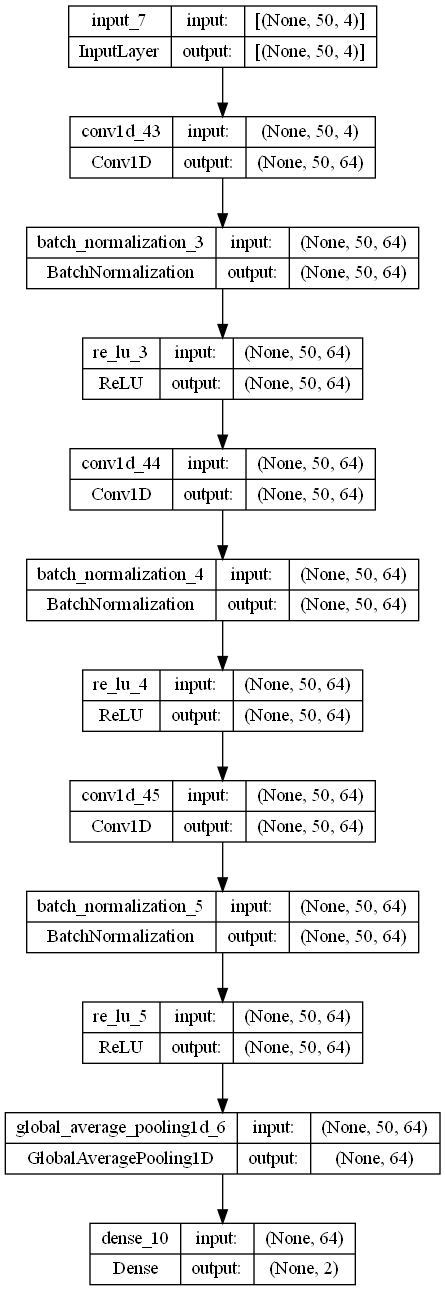

In [28]:
model = make_model(input_shape=ohlc_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

### 3. Train the model

In [29]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    ohlc_train,
    trend_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
8/8 [==============================] - 2s 35ms/step - loss: 0.7149 - sparse_categorical_accuracy: 0.6017 - val_loss: 0.5842 - val_sparse_categorical_accuracy: 0.7119 - lr: 0.0010
Epoch 2/500
8/8 [==============================] - 0s 9ms/step - loss: 0.6582 - sparse_categorical_accuracy: 0.6441 - val_loss: 0.6102 - val_sparse_categorical_accuracy: 0.7119 - lr: 0.0010
Epoch 3/500
8/8 [==============================] - 0s 10ms/step - loss: 0.6707 - sparse_categorical_accuracy: 0.6441 - val_loss: 0.5874 - val_sparse_categorical_accuracy: 0.7119 - lr: 0.0010
Epoch 4/500
8/8 [==============================] - 0s 15ms/step - loss: 0.6446 - sparse_categorical_accuracy: 0.6483 - val_loss: 0.5788 - val_sparse_categorical_accuracy: 0.7119 - lr: 0.0010
Epoch 5/500
8/8 [==============================] - 0s 9ms/step - loss: 0.6555 - sparse_categorical_accuracy: 0.6483 - val_loss: 0.5947 - val_sparse_categorical_accuracy: 0.7119 - lr: 0.0010
Epoch 6/500
8/8 [==============================

Epoch 44/500
8/8 [==============================] - 0s 9ms/step - loss: 0.6377 - sparse_categorical_accuracy: 0.6525 - val_loss: 0.6100 - val_sparse_categorical_accuracy: 0.7119 - lr: 5.0000e-04
Epoch 45/500
8/8 [==============================] - 0s 9ms/step - loss: 0.6386 - sparse_categorical_accuracy: 0.6483 - val_loss: 0.6009 - val_sparse_categorical_accuracy: 0.7119 - lr: 5.0000e-04
Epoch 46/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6429 - sparse_categorical_accuracy: 0.6483 - val_loss: 0.6081 - val_sparse_categorical_accuracy: 0.7119 - lr: 5.0000e-04
Epoch 47/500
8/8 [==============================] - 0s 9ms/step - loss: 0.6464 - sparse_categorical_accuracy: 0.6483 - val_loss: 0.5911 - val_sparse_categorical_accuracy: 0.7119 - lr: 5.0000e-04
Epoch 48/500
8/8 [==============================] - 0s 10ms/step - loss: 0.6511 - sparse_categorical_accuracy: 0.6483 - val_loss: 0.5801 - val_sparse_categorical_accuracy: 0.7119 - lr: 5.0000e-04
Epoch 49/500
8/8 [======

### 4. Evaluate model on test data

In [31]:
model = keras.models.load_model("best_model2.h5")

test_loss, test_acc = model.evaluate(ohlc_test, trend_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

OSError: No file or directory found at best_model2.h5

### 4. Plot the model's training and validation loss

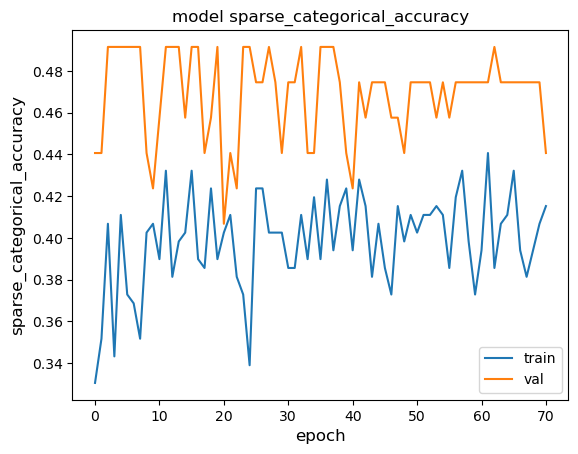

In [31]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [10]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [13]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [26]:
input_shape = ohlc_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    ohlc_train,
    trend_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(ohlc_test, trend_test, verbose=1)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50, 4)]      0           []                               
                                                                                                  
 multi_head_attention_16 (Multi  (None, 50, 4)       19460       ['input_6[0][0]',                
 HeadAttention)                                                   'input_6[0][0]']                
                                                                                                  
 dropout_36 (Dropout)           (None, 50, 4)        0           ['multi_head_attention_16[0][0]']
                                                                                                  
 layer_normalization_32 (LayerN  (None, 50, 4)       8           ['dropout_36[0][0]']       

 ambda)                                                           'tf.__operators__.add_37[0][0]']
                                                                                                  
 conv1d_41 (Conv1D)             (None, 50, 4)        20          ['tf.__operators__.add_38[0][0]']
                                                                                                  
 dropout_43 (Dropout)           (None, 50, 4)        0           ['conv1d_41[0][0]']              
                                                                                                  
 conv1d_42 (Conv1D)             (None, 50, 4)        20          ['dropout_43[0][0]']             
                                                                                                  
 layer_normalization_39 (LayerN  (None, 50, 4)       8           ['conv1d_42[0][0]']              
 ormalization)                                                                                    
          

[54.51728820800781, 0.6771653294563293]

In [18]:
model.evaluate(ohlc_test, trend_test, verbose=1)

4/4 [==============================] - 1s 140ms/step - loss: 407.0147 - sparse_categorical_accuracy: 0.4094


[407.0146789550781, 0.4094488322734833]

In [19]:
import keras_tuner

build_model(keras_tuner.HyperParameters())

TypeError: build_model() missing 5 required positional arguments: 'head_size', 'num_heads', 'ff_dim', 'num_transformer_blocks', and 'mlp_units'

In [21]:
model.fit(
    ohlc_train,
    trend_train,
    validation_split=0.3,
    epochs=200,
    batch_size=128,
    callbacks=callbacks,
)

Epoch 1/200
2/2 [==============================] - 3s 1s/step - loss: 589.9896 - sparse_categorical_accuracy: 0.3204 - val_loss: 112.7823 - val_sparse_categorical_accuracy: 0.3708
Epoch 2/200
2/2 [==============================] - 3s 1s/step - loss: 558.9009 - sparse_categorical_accuracy: 0.3350 - val_loss: 109.1985 - val_sparse_categorical_accuracy: 0.3708
Epoch 3/200
2/2 [==============================] - 2s 1s/step - loss: 408.2508 - sparse_categorical_accuracy: 0.3641 - val_loss: 107.4538 - val_sparse_categorical_accuracy: 0.3708
Epoch 4/200
2/2 [==============================] - 2s 1s/step - loss: 522.1568 - sparse_categorical_accuracy: 0.3155 - val_loss: 108.6109 - val_sparse_categorical_accuracy: 0.3708
Epoch 5/200
2/2 [==============================] - 2s 1s/step - loss: 489.6100 - sparse_categorical_accuracy: 0.2913 - val_loss: 113.3810 - val_sparse_categorical_accuracy: 0.3708
Epoch 6/200
2/2 [==============================] - 3s 1s/step - loss: 474.1072 - sparse_categorical_

In [13]:
rawfile = open_file('h5py', 'raw data/daily_futures.h5', mode="r")
model = load_model('../../data/keras models/trend_20day.h5')
savefile = open_file('h5py', 'custom/ohlc_trend(20).h5', mode="w")

In [14]:
'''
index N의 trend index는
N-period 에서 N-1 동안의 period 일에 대한 trend index임

'''
window = 20
for idx, file in enumerate(rawfile.values()):
    if file.attrs['symbol'] == 'None':
        continue
    
    name = file.attrs['name']
    print("\rprocessing %s...(%s/%s)            "%(name, idx, len(rawfile)),end='', flush=True)
    columns = ['date', 'open','high','low','close','volume','open interest']
    raw_data = pd.DataFrame(file.value, columns=columns)
    trend=[np.nan for i in range(window)]
    
    for i in range(window, len(raw_data)):
        data = raw_data[i-window:i][['open','high','low','close']]
        data = norm(data)
        
        pred = model.predict(np.array([data.values]))[0]
        #trend.append(pred.argmax())
        
        if pred[0] > pred[2]: #downtrend
            trend.append(-pred[0])
        else: #uptrend
            trend.append(pred[2])
        
    raw_data['trend'] = pd.DataFrame(trend)
    raw_data = raw_data[window:][['date','open','high','low','close','trend']]
    dset = savefile.create_dataset(file.attrs['symbol'], shape=raw_data.shape, data=raw_data.values)
    dset.attrs['name'] = file.attrs['name']
    dset.attrs['symbol'] = file.attrs['symbol']

processing ICE Russell 2000 Index Mini...(63/77)              

In [15]:
savefile.attrs['columns'] = 'date;open;high;low;close;trend'

In [16]:
rawfile.close()
savefile.close()

In [30]:
from collections import Counter

In [17]:
raw_data['date'] = raw_data.date.astype('M8[s]')

In [18]:
raw_data.set_index('date',inplace=True)

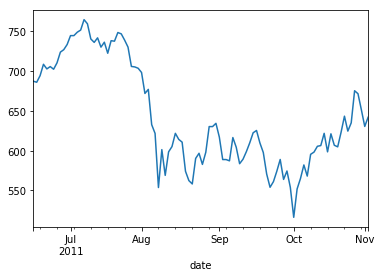

In [19]:
raw_data.iloc[1200:1300].close.plot()

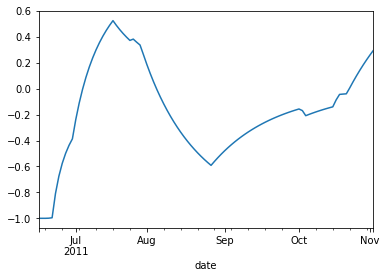

In [20]:
raw_data.iloc[1200:1300].trend.ewm(20).mean().plot()

In [21]:
f = h5py.File(trainedfile, "r")

In [38]:
trend = np.array([])
for file in f.values():
    trend = np.append(trend, file.value[:,4])

In [42]:
Counter(trend)

Counter({0.0: 30492, 1.0: 105057, 2.0: 47026})

In [27]:
v.attrs['symbol']

'None'

In [26]:
np.hstack(([[1],[2]],[[3],[4]]))

array([[1, 3],
       [2, 4]])

In [8]:
a=[[1,2,3],[4,5,6]]

In [9]:
pd.DataFrame(a)

,0,1,2
0,1,2,3
1,4,5,6


In [3]:
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split

In [16]:
# flatten the images
n_samples = len(ohlc)
data = ohlc.reshape((n_samples, -1))

In [30]:
clf = svm.SVC()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    data, trend, test_size=0.5, shuffle=False
)

In [32]:
clf.fit(X_train, y_train)

SVC()

In [33]:
predicted = clf.predict(X_test)

In [34]:
predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [35]:
s = y_test==predicted

In [36]:
len(s[s==True])/len(s)

0.36492890995260663

In [ ]:
# flatten the images
n_samples = len(ohlc)
data = ohlc.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    ohlc, digits.target, test_size=0.5, shuffle=False
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)